In [5]:
import numpy as np
import argparse
import os, time

from pykin.utils import plot_utils as p_utils

from pytamp.benchmark import Rearrange1

from pytamp.action.pick import PickAction
from pytamp.action.rearrangement import RearrangementAction

from pytamp.benchmark.rearrange1 import make_scene
from pytamp.search.mcts_for_rearragement import MCTS_rearrangement
from pykin.utils.kin_utils import ShellColors as sc
from pytamp.utils.point_cloud_utils import *

def get_parser():
    parser = argparse.ArgumentParser(description="Test Rearragement 1.")
    parser.add_argument("--budgets", metavar="T", type=int, default=150, help="Horizon")
    parser.add_argument("--max_depth", metavar="H", type=int, default=20, help="Max depth")
#     parser.add_argument("--seed", metavar="i", type=int, default=7, help="A random seed")
    parser.add_argument("--seed", metavar="i", type=int, default=144, help="A random seed")
    parser.add_argument(
        "--algo",
        metavar="alg",
        type=str,
        default="bai_perturb",
        choices=["bai_perturb", "bai_ucb", "uct", "random", "greedy"],
        help="Choose one (bai_perturb, bai_ucb, uct)",
    )
    parser.add_argument(
        "--debug_mode", default=False, type=lambda x: (str(x).lower() == "true"), help="Debug mode"
    )
#     parser.add_argument("--box_number", metavar="N", type=int, default=6, help="Box Number(6 or less)")
    try:
        args = parser.parse_args() #call from command line
    except:
        args = parser.parse_args(args=[]) #call from notebook
    return args 

args = get_parser() 

debug_mode = args.debug_mode
budgets = args.budgets
max_depth = args.max_depth
algo = args.algo
seed = args.seed
np.random.seed(seed)

object_names, init_scene, goal_scene = make_scene()
rearrangement1 = Rearrange1('doosan', object_names, init_scene, goal_scene, is_pyplot=False)

final_level_1_values = []
final_level_2_values = []
final_optimal_nodes = []
final_pnp_all_joint_paths = []
final_pick_all_objects = []
final_place_all_object_poses = []

# final_optimal_trees = []
c_list = 10 ** np.linspace(-2, 2.0, 10)


usage: ipykernel_launcher.py [-h] [--budgets T] [--max_depth H] [--seed i]
                             [--algo alg] [--debug_mode DEBUG_MODE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/juju/.local/share/jupyter/runtime/kernel-a3945ad7-6e0d-4e32-822e-4b5f8a9dea26.json


*********************** Logical States ***********************
OrderedDict([('ben_cube0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('can0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('can1',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('milk0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('cereal0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('table',
              {'static': True,
               'support': [Object(name=ben_cube0, pos=[0.30355822 0.00852862 0.84779998]),
                           Object(name=can0, pos=[0.39698326 0.00357495 0.83501831]),
                           Object(name=can1, pos=[0.76977701 0.03858527 0.83512874]),
                           Object(name=milk0, pos=[ 0.48530145 -0.34550815  0.83236691]),
                           Object(name=cereal0, pos=[0.4

{'table': Object(name=table, pos=[ 0.9   -0.6    0.043]), 'ben_cube0': Object(name=ben_cube0, pos=[0.30355822 0.00852862 0.84779998]), 'can0': Object(name=can0, pos=[0.39698326 0.00357495 0.83501831]), 'can1': Object(name=can1, pos=[0.76977701 0.03858527 0.83512874]), 'milk0': Object(name=milk0, pos=[ 0.48530145 -0.34550815  0.83236691]), 'cereal0': Object(name=cereal0, pos=[0.43695543 0.12948806 0.88526188])}


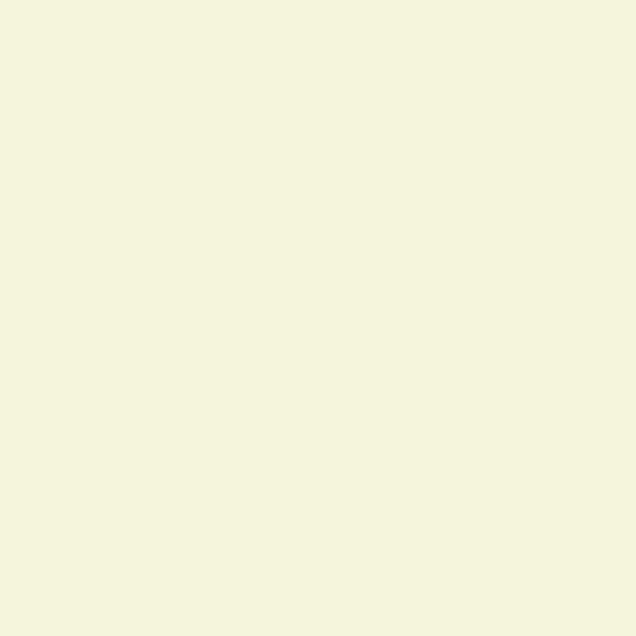

In [2]:
#######################
fig, ax = p_utils.init_3d_figure(name="Rearrangement 1")
# init_scene
rearrangement1.scene_mngr.render_scene(ax)
rearrangement1.render_axis(rearrangement1.scene_mngr)
# rearrangement1.render_axis_2(rearrangement1.scene_mngr)
rearrangement1.scene_mngr.show()


In [6]:
rearrangement1.scene_mngr.scene.objs

for name,i in rearrangement1.scene_mngr.scene.objs.items():
    print(name ,i.gparam.centroid, i.gparam.center_mass, i.h_mat)

table [-0.20618468  0.59472148  0.50044544] [-0.21475407  0.59472146  0.52605846] [[ 1.     0.     0.     0.9  ]
 [ 0.     1.     0.    -0.6  ]
 [ 0.     0.     1.     0.043]
 [ 0.     0.     0.     1.   ]]
ben_cube0 [0. 0. 0.] [0. 0. 0.] [[ 0.         -0.90181322 -0.43212604  0.30355822]
 [ 0.          0.43212604 -0.90181322  0.00852862]
 [ 1.          0.          0.          0.84779998]
 [ 0.          0.          0.          1.        ]]
can0 [ 7.37974419e-05 -2.69046060e-04  1.06250259e-03] [5.55561743e-09 1.07922916e-08 9.06032271e-09] [[-0.51161063 -0.66674519 -0.54194595  0.39698326]
 [ 0.3299154   0.42995492 -0.84041334  0.00357495]
 [ 0.79335389 -0.60876072  0.          0.83501831]
 [ 0.          0.          0.          1.        ]]
can1 [ 7.37974419e-05 -2.69046060e-04  1.06250259e-03] [5.55561743e-09 1.07922916e-08 9.06032271e-09] [[-0.49842423  0.64955856 -0.57414891  0.76977701]
 [-0.3495199   0.45550281  0.8187509   0.03858527]
 [ 0.79335309  0.60876175  0.          0.8351

In [11]:
point_clouds, _

(array([[ 0.29978547, -0.03124647,  0.88320583],
        [ 0.27663053,  0.03911287,  0.82074663],
        [ 0.27692153, -0.01844133,  0.81029998],
        ...,
        [ 0.42008209,  0.14321756,  0.81029998],
        [ 0.41410379,  0.11346946,  0.87990606],
        [ 0.43582948,  0.11442014,  0.83816432]]),
 3)

5000


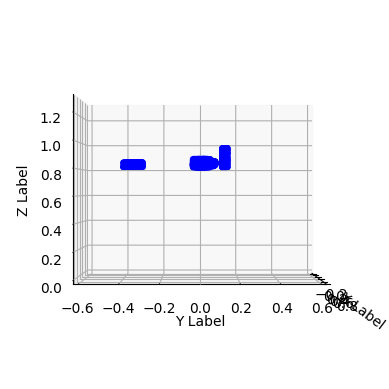

In [24]:
%matplotlib inline
import trimesh
from trimesh.util import concatenate

point_clouds, _ = get_obj_point_clouds(rearrangement1.init_scene,rearrangement1.scene_mngr.scene, "milk0")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print(len(point_clouds))

# matplotlib으로 point cloud 시각화하기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_clouds[:, 0], point_clouds[:, 1], point_clouds[:, 2], c='b', marker='.')
ax.set_xlim(-0.2,0.8)
ax.set_ylim(-0.6,0.6)
ax.set_zlim(0,1.3)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.view_init(elev=0, azim=0)

plt.show()


In [13]:
support_polys, support_T , sup_obj_name= rearrangement1.init_scene._get_support_polygons()


# Sample support index
support_index = max(enumerate(support_polys), key=lambda x: x[1].area)[0]

In [14]:
pts = trimesh.path.polygons.sample(
                    support_polys[support_index], count=3000
                )

# z_arr = np.full((len(pts), 1), support_T[support_index][2,3])
z_arr = np.full((len(pts), 1), 0)
o_arr = np.full((len(pts), 1), 1)

sup_point_cloud = np.hstack((pts, z_arr))
sup_point_cloud2 = np.hstack((sup_point_cloud, o_arr))

transformed_point_cloud = sup_point_cloud + support_T[support_index][:3,3] + rearrangement1.scene_mngr.scene.objs['table'].h_mat[:3,3]

In [15]:
transformed_point_cloud

array([[ 0.59912389,  0.53283368,  0.80829998],
       [ 0.75319847,  0.18444359,  0.80829998],
       [ 0.33218972, -0.50953486,  0.80829998],
       ...,
       [ 0.5255525 , -0.37498154,  0.80829998],
       [ 0.80311619, -0.16152934,  0.80829998],
       [ 0.44593141,  0.35115201,  0.80829998]])

In [16]:
sup_point_cloud2 , support_T[support_index][:3]

(array([[-0.34087611, -0.09625731,  0.        ,  1.        ],
        [-0.18680153, -0.4446474 ,  0.        ,  1.        ],
        [-0.60781028, -1.13862585,  0.        ,  1.        ],
        ...,
        [-0.4144475 , -1.00407253,  0.        ,  1.        ],
        [-0.13688381, -0.79062033,  0.        ,  1.        ],
        [-0.49406859, -0.27793898,  0.        ,  1.        ]]),
 array([[1.        , 0.        , 0.        , 0.04      ],
        [0.        , 1.        , 0.        , 1.22909099],
        [0.        , 0.        , 1.        , 0.76529998]]))

In [17]:
(np.dot(support_T[support_index][:3], sup_point_cloud2.T).T + rearrangement1.scene_mngr.scene.objs['table'].h_mat[:3,3])

array([[ 0.59912389,  0.53283368,  0.80829998],
       [ 0.75319847,  0.18444359,  0.80829998],
       [ 0.33218972, -0.50953486,  0.80829998],
       ...,
       [ 0.5255525 , -0.37498154,  0.80829998],
       [ 0.80311619, -0.16152934,  0.80829998],
       [ 0.44593141,  0.35115201,  0.80829998]])

In [18]:
pts = rearrangement1.get_support_space_point_cloud()

AttributeError: 'Rearrange1' object has no attribute 'get_support_space_point_cloud'

In [20]:
point_clouds = np.vstack((point_clouds, pts))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 2

5000


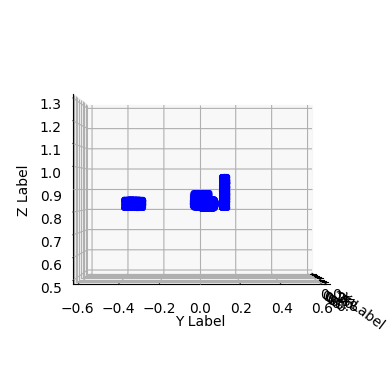

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print(len(point_clouds))

# matplotlib으로 point cloud 시각화하기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_clouds[:, 0], point_clouds[:, 1], point_clouds[:, 2], c='b', marker='.')
ax.set_xlim(-0.,0.8)
ax.set_ylim(-.6,0.6)
ax.set_zlim(0.5,1.3)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.view_init(elev=0, azim=0)

plt.show()


## sd 

In [38]:
obj_name = 'table'
from copy import deepcopy
support_obj = rearrangement1.scene_mngr.scene.objs[obj_name]
copied_mesh = deepcopy(support_obj.gparam)
copied_mesh.apply_transform(support_obj.h_mat)
center_point = copied_mesh.center_mass

In [52]:
min_area=0.01
gravity=np.array([0, 0, -1.0])
erosion_distance=0.02

support_polygons = []
support_polygons_T = []

support_facet_indices = np.argsort(copied_mesh.facets_area)

support_facet_indices = [
    idx
    for idx in support_facet_indices
    if np.isclose(copied_mesh.facets_normal[idx].dot(-gravity), 1.0, atol=0.5)
    and copied_mesh.facets_area[idx] > min_area
]

for inds in support_facet_indices:
    index = inds
    normal = copied_mesh.facets_normal[index]
    origin = copied_mesh.facets_origin[index]
    
    T = trimesh.geometry.plane_transform(origin, normal)
    vertices = trimesh.transform_points(copied_mesh.vertices, T)[:, :2]
    
    # find boundary edges for the facet
    edges = copied_mesh.edges_sorted.reshape((-1, 6))[
        copied_mesh.facets[index]
    ].reshape((-1, 2))
    group = trimesh.grouping.group_rows(edges, require_count=1)

    # run the polygon conversion
    polygon = trimesh.path.polygons.edges_to_polygons(
        edges=edges[group], vertices=vertices
    )

    assert len(polygon) == 1

    # erode to avoid object on edges
    polygon[0] = polygon[0].buffer(-erosion_distance)

    if not polygon[0].is_empty and polygon[0].area > min_area:
        support_polygons.append(polygon[0])
        support_polygons_T.append(trimesh.transformations.inverse_matrix(T))
        


In [56]:
support_polygons[1].centroid.x, support_polygons[1].centroid.y

(-0.3399999924004078, -0.6343694943934679)

In [26]:
support_polys, support_T , sup_obj_name= rearrangement1.init_scene._get_support_polygons()


# Sample support index
support_index = max(enumerate(support_polys), key=lambda x: x[1].area)[0]

AttributeError: 'Polygon' object has no attribute 'sample'

In [20]:
rearrangement1.init_scene._objects['table'].center_mass

array([-0.21475407,  0.59472146,  0.52605846])

In [ ]:
def get_sup_polygons(min_area=0.01, 
                     gravity=np.array([0, 0, -1.0]), 
                     erosion_distance=0.02
    ):
    assert np.isclose(np.linalg.norm(gravity), 1.0)

    support_polygons = []
    support_polygons_T = []
    # Add support plane if it is set (although not infinite)
    support_meshes = self._support_objects

    for obj_name, obj_mesh in support_meshes.items():
        # get all facets that are aligned with -gravity and bigger than min_area
        support_facet_indices = np.argsort(obj_mesh.facets_area)
        support_facet_indices = [
            idx
            for idx in support_facet_indices
            if np.isclose(obj_mesh.facets_normal[idx].dot(-gravity), 1.0, atol=0.5)
            and obj_mesh.facets_area[idx] > min_area
        ]

## sd 

In [6]:
import numpy as np
from trimesh.util import concatenate

# 비어있는 TrackedArray 생성
tracked_arr = concatenate([])
tracked_arr

[]

In [133]:
matrix = np.eye(4).reshape(1, 4, 4) * np.ones((10000, 1, 1))
matrix[:,:3,-1] = points

In [141]:
can_point_cloud_in_scene = can.h_mat @ matrix

In [143]:
np.where(can_point_cloud_in_scene[:,2,3])

(array([   0,    1,    2, ..., 9997, 9998, 9999]),)

In [145]:
support_polys, support_T , sup_obj_name= rearrangement1.init_scene._get_support_polygons()
support_index = max(enumerate(support_polys), key=lambda x: x[1].area)[0]


support_polys[support_index].centroid.x, support_polys[support_index].centroid.y 

table_center = support_T[support_index][:3,3]

In [171]:
rearrangement1.scene_mngr.scene.objs['can0'].gparam.center_mass

array([5.55561743e-09, 1.07922916e-08, 9.06032271e-09])

In [176]:
from copy import deepcopy
obj_name = 'can0'
copied_mesh = rearrangement1.scene_mngr.scene.objs[obj_name].gparam
copied_mesh.apply_translation(-copied_mesh.center_mass)
copied_mesh.apply_transform(rearrangement1.scene_mngr.scene.objs[obj_name].h_mat)

copied_mesh.sample(100)

TrackedArray([[ 0.41946963,  0.02725972,  0.81103323],
              [ 0.40088323,  0.04788476,  0.83349189],
              [ 0.38965373, -0.00497945,  0.85987223],
              [ 0.3944567 , -0.03766178,  0.83283635],
              [ 0.40483131, -0.01615992,  0.81726176],
              [ 0.38258589,  0.02394446,  0.82590808],
              [ 0.39890045, -0.01984092,  0.85548574],
              [ 0.40507221,  0.01745926,  0.81029998],
              [ 0.43843453,  0.02212502,  0.83859324],
              [ 0.42005985,  0.03198486,  0.85969224],
              [ 0.36517251, -0.01425586,  0.8171664 ],
              [ 0.40400739,  0.04676585,  0.85037547],
              [ 0.36444992, -0.01831171,  0.84927772],
              [ 0.4017177 ,  0.04475045,  0.83462083],
              [ 0.41318636,  0.03735481,  0.83456153],
              [ 0.4337181 ,  0.02703328,  0.82226535],
              [ 0.4317417 ,  0.02538928,  0.82989973],
              [ 0.38206844,  0.02356586,  0.82676531],
          

In [178]:
rearrangement1.scene_mngr.scene.objs[obj_name].gparam.center_mass

array([0.39698325, 0.00357495, 0.83501823])